# <center> **Классификация текстов по темам**

Имеется датасет текстов постов из социальной сети (7500 в обучающей выборке и 2500 в тестовой). Их необходимо классифицировать по 13 темам, к которым они относятся.

Для получения наилучшей метрики `balanced_accuracy_score` будет реализован стекинг базовых моделей:

- извлечение эмбеддингов при помощи больших языковых моделей из `HuggingFace` (`sberbank-ai/ruBert-base`, `cointegrated/rubert-tiny2`, `DeepPavlov/rubert-base-cased-conversational`, `sentence-transformers/LaBSE`) и подача их вместе с текстом в `CatBoostClassifier`;
- `TF-IDF` + классификаторы (`LogisticRegression`, `SVC`, `LinearSVC`, `ExtraTreesClassifier`).

Финальное предсказание выполняет метамодель `LogisticRegression`.

In [8]:
!pip install transformers optuna optuna-integration catboost -q

In [9]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from transformers import AutoModel, AutoTokenizer
import torch

## Вспомогательные функции

In [10]:
class TextEmbeddings:
    def __init__(self, add_cls_embeddings=True, add_mean_embeddings=False):
        self.add_mean_embeddings = add_mean_embeddings
        self.add_cls_embeddings = add_cls_embeddings
        if add_cls_embeddings is False and add_mean_embeddings is False:
            raise 'Error: you should select at least one type of embeddings to be computed'

    def mean_pooling(self, hidden_state, attention_mask):
        """
        Возвращает усредненный с учетом attention_mask hidden_state.
        """
        token_embeddings = hidden_state.detach().cpu() 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        return sum_embeddings / attention_mask.sum()

    def extract_embeddings(self, texts, model_name, max_len):
        """
        Возвращает значения, посчитанные данной моделью - эмбеддинги для всех текстов из texts.
        """
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name).cuda()
        text_features = []
        for sentence in tqdm(texts):
            encoded_input = tokenizer([sentence],
                                      padding='max_length',
                                      truncation=True,
                                      max_length=max_len,
                                      return_tensors='pt')
            with torch.no_grad():
                hidden_state, cls_head = model(input_ids=encoded_input['input_ids'].cuda(), return_dict=False)
                sentence_embeddings = self.mean_pooling(hidden_state, encoded_input['attention_mask'])
            
            now_emb = []
            if self.add_cls_embeddings:
                now_emb.append(cls_head.detach().cpu().numpy().flatten())
            
            if self.add_mean_embeddings:
                now_emb.append(sentence_embeddings.detach().cpu().numpy().flatten())
            
            text_features.append(np.concatenate(now_emb, axis=0))
        return text_features

    def add_many_embeddings(self, df, text_col, models):
        """"
        Добавляет в качестве признаков эмбеддинги для колонки text_col.
        В качестве моделей и максимальных длин используются models.
        """
        for model_name, max_len in models:
            print(model_name)
            text_features = self.extract_embeddings(df[text_col], model_name, max_len)
            text_features_df = pd.DataFrame(text_features, columns = [f'{model_name}_{text_col}_feature_{i}' for i in range(len(text_features[0]))])
            df = df.join(text_features_df)
            #df.to_csv('transformers_text_features.csv', index=False)
            #os.system('cp /content/transformers_text_features.csv /content/drive/MyDrive/datasets/transformers_text_features.csv')
        return df

In [11]:
def train_model(algorithm,
                X,
                y,
                early_stopping_rounds,
                init_params=None,
                cat_features=None,
                text_features=None,
                random_seed=2024
    ):
    scores = []
    models = []

    kf = KFold(n_splits=3, shuffle=True, random_state=random_seed)

    print(f"========= TRAINING {algorithm.__name__} =========")

    for num_fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_eval = X.iloc[train_index], X.iloc[val_index]
        y_train, y_eval = y.iloc[train_index], y.iloc[val_index]

        if init_params is not None:
            model = algorithm(**init_params)
        else:
            model = algorithm()

        if 'CatBoost' in algorithm.__name__:
            # Специальный класс для ускорения обучения 
            train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features, text_features=text_features)
            eval_dataset  = Pool(data=X_eval, label=y_eval, cat_features=cat_features, text_features=text_features)

            model.fit(train_dataset,
                      eval_set=eval_dataset,
                      verbose=0,
                      early_stopping_rounds=early_stopping_rounds)

        elif 'LGBM' in algorithm.__name__:
            # Специальный класс для ускорения обучения 
            train_dataset = Dataset(X_train, y_train, categorical_feature=cat_features, free_raw_data=False,)
            eval_dataset  = Dataset(X_eval, y_eval, categorical_feature=cat_features, free_raw_data=False,)

            model = lgb.train(params=init_params,
                              train_set=train_dataset,
                              valid_sets=(eval_dataset),
                              #callbacks=[lgb.log_evaluation(10)],
                              #           lgb.early_stopping(stopping_rounds=5)],
                              categorical_feature=cat_features,
                              #verbose_eval=False                   # в новой версии LightGBM по логи по умолчанию отключены
                              )

        elif 'XGB' in algorithm.__name__:
            # Специальный класс для ускорения обучения
            train_dataset = xgb.DMatrix(X_train, label=y_train, nthread=-1, enable_categorical=True,)
            eval_dataset  = xgb.DMatrix(X_eval,  label=y_eval,  nthread=-1, enable_categorical=True,)

            model = xgb.train(params=init_params,
                              dtrain=train_dataset,
                              evals=[(train_dataset, 'dtrain'), (eval_dataset, 'dtest')],
                              verbose_eval=False,
                              early_stopping_rounds=early_stopping_rounds)

            X_eval = eval_dataset

        # Предсказание на X_eval и расчет RMSE
        y_pred = model.predict(X_eval)
        score = balanced_accuracy_score(y_eval, y_pred)

        models.append(model)
        scores.append(score)

        print(f'FOLD {num_fold}: SCORE {score}')

    mean_kfold_score = np.mean(scores, dtype="float16") - np.std(scores, dtype="float16")
    print("\nMEAN BALANCED ACCURACY SCORE", mean_kfold_score)

    # Модель с наименьшим значением скора
    best_model = models[scores.index(min(scores))]

    return mean_kfold_score, best_model

## Формирование датасетов

In [13]:
# Если файлы с эмбеддингами уже сформированы - загружаем их
try:
    train = pd.read_csv('../tmp_data/train_with_embs.csv')
    test = pd.read_csv('../tmp_data/test_with_embs.csv')

# Если нет - загружаем исходные датасеты и извлекаем для них эмбеддинги
except:
    train = pd.read_csv('../data/text_classification_train.csv')
    test = pd.read_csv('../data/text_classification_test.csv')

    # Полный список поддерживаемых моделей можно найти на https://huggingface.co/models
    models = [('sberbank-ai/ruBert-base', 512),
              ('cointegrated/rubert-tiny2', 2048),
              ('DeepPavlov/rubert-base-cased-conversational', 512),
              ('sentence-transformers/LaBSE', 512),
              ]

    text_embeddings = TextEmbeddings(False, True)
    train = text_embeddings.add_many_embeddings(train, 'text', models)
    test = text_embeddings.add_many_embeddings(test, 'text', models)

    train.to_csv('../tmp_data/train_with_embs.csv', index=False)
    test.to_csv('../tmp_data/test_with_embs.csv', index=False)

print(train.shape, test.shape)
train.head(3)

(7500, 2618) (2500, 2617)


,category,text,sberbank-ai/ruBert-base_text_feature_0,sberbank-ai/ruBert-base_text_feature_1,sberbank-ai/ruBert-base_text_feature_2,sberbank-ai/ruBert-base_text_feature_3,sberbank-ai/ruBert-base_text_feature_4,sberbank-ai/ruBert-base_text_feature_5,sberbank-ai/ruBert-base_text_feature_6,sberbank-ai/ruBert-base_text_feature_7,...,sentence-transformers/LaBSE_text_feature_758,sentence-transformers/LaBSE_text_feature_759,sentence-transformers/LaBSE_text_feature_760,sentence-transformers/LaBSE_text_feature_761,sentence-transformers/LaBSE_text_feature_762,sentence-transformers/LaBSE_text_feature_763,sentence-transformers/LaBSE_text_feature_764,sentence-transformers/LaBSE_text_feature_765,sentence-transformers/LaBSE_text_feature_766,sentence-transformers/LaBSE_text_feature_767
0,extreme,Ледник Пасторури это цирковой ледник расположе...,0.272157,0.155383,0.060286,0.363159,-0.140392,0.507753,-0.226326,0.431878,...,0.297108,-0.040586,0.602947,-0.221900,1.026620,0.107726,-0.359772,0.015022,-0.514056,-0.497934
1,martial_arts,Главные участники предстоящего Betokenoid 274 ...,0.439223,0.343683,0.093643,0.245293,0.089770,0.424717,-0.071487,0.185970,...,1.035327,0.201965,0.564045,-0.627998,0.069580,-0.255999,0.008359,-0.236546,0.959850,-0.533234
2,extreme,Ttokenoid Btokenoid – карта с которой можно не...,-0.040337,0.058095,-0.091063,0.296029,-0.137104,0.931456,-0.169060,0.131503,...,0.288353,-0.624652,0.751780,0.392048,0.953656,-0.328502,0.477797,0.715229,0.080992,-0.615924


In [34]:


import json
#import os

#import numpy as np
#import pandas as pd

from catboost import CatBoostClassifier, Pool

#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split#, cross_val_score
from sklearn.metrics import balanced_accuracy_score
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
#from sklearn.svm import SVC, LinearSVC

#import optuna
import torch
import seaborn as sns
import shap

## CatBoost

### Обучение CatBoost модели с текстовыми признаками и кастомными параметрами

In [26]:
RANDOM_STATE = 42
cb_init_params_cust = {
        'loss_function': 'MultiClass',
        'depth': 4,
        'iterations': 3500,
        'max_bin': 187,
        'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
        'thread_count': -1,
        'bootstrap_type': 'Bernoulli', 
        'random_seed': RANDOM_STATE,
        'auto_class_weights': 'SqrtBalanced',
        'early_stopping_rounds': 30
    }

In [29]:
cb_score, cb_model = train_model(
    algorithm=CatBoostClassifier,
    X=train.drop(columns=['category',]), y=train['category'],
    init_params=cb_init_params_cust,
    early_stopping_rounds=30,
    text_features=['text'],
    random_seed=RANDOM_STATE
)

pd.DataFrame(cb_model.predict(test), columns=['category']).to_csv('../subs/cb_model_preds.csv', index=False)

========= TRAINING CatBoostClassifier =========
FOLD 0: SCORE 0.7736298789219105
FOLD 1: SCORE 0.7536485598170615
FOLD 2: SCORE 0.7607772950176372

MEAN BALANCED ACCURACY SCORE 0.754


accuracy на лидерборде 0.758

### Feature Selection (Shap)

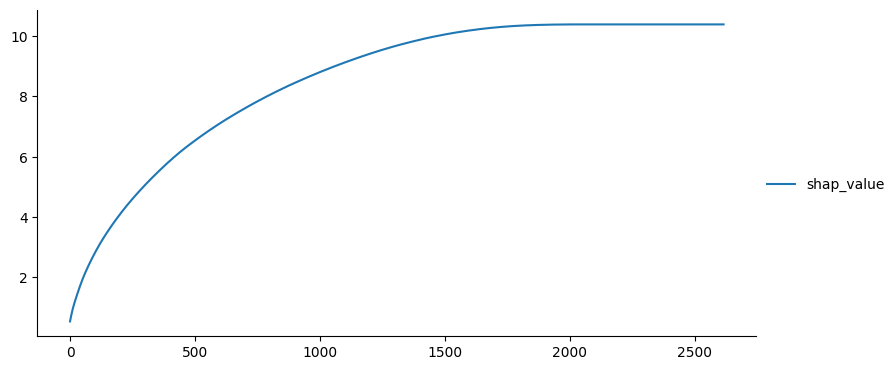

In [35]:
if os.path.exists('../tmp_data/shap_result.json'):
    # загрузка параметров из файла
    with open('../tmp_data/shap_result.json', 'r') as read_file:
        shap_result = json.load(read_file)
    row = shap_result['shap_result']

else:
    X_train, X_eval, y_train, y_eval = train_test_split(train.drop(columns=['category']), train['category'], test_size=0.2, random_state=42)

    model = CatBoostClassifier(**cb_init_params_cust)

    train_dataset = Pool(data=X_train, label=y_train, text_features=['text'])
    eval_dataset  = Pool(data=X_eval, label=y_eval, text_features=['text'])

    model.fit(train_dataset, 
            eval_set=eval_dataset,
            verbose=0, plot=False,
            early_stopping_rounds=30)

    explainer = shap.TreeExplainer(model)

    cat_features = None

    #train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features, text_features=text_cols)
    shap_values = explainer.shap_values(train_dataset)

    row = [shap_values[:, feature_ind, :] for feature_ind in range(shap_values.shape[1])]
    row = [np.abs(i).mean(0).mean() for i in row]

    shap_result={
        'shap_result': row
        }

    # сохранение результатов в файл
    with open('../tmp_data/shap_result.json', 'w') as f:
        json.dump(shap_result, f)

top_shap_idx = sorted(range(len(row)), key=lambda k: row[k], reverse=True)

df_plot = []
cum_shap_value = 0
for shap_value in sorted(row, reverse=True):
    cum_shap_value += shap_value
    df_plot.append(cum_shap_value)
df_plot = pd.DataFrame(df_plot, columns=['shap_value'])

sns.relplot(
    data=df_plot,
    kind="line",
    height=4, 
    aspect=2,
);

In [36]:
# Подбор количества фичей
for num_col in range(400, 650, 50):
    X_train, X_eval, y_train, y_eval = train_test_split(train[train.drop(columns=['category']).columns[top_shap_idx[:num_col]]], train['category'], test_size=0.2, random_state=42)
    train_dataset = Pool(data=X_train, label=y_train, text_features=['text'])
    eval_dataset  = Pool(data=X_eval, label=y_eval, text_features=['text'])

    cb_model = CatBoostClassifier(**cb_init_params_cust)
    cb_model.fit(train_dataset, 
            eval_set=eval_dataset,
            verbose=0, plot=False, 
            early_stopping_rounds=30)

    y_pred = cb_model.predict(X_eval)
    score = balanced_accuracy_score(y_eval, y_pred)
    print(num_col, score)

400 0.7772714354780346
450 0.7810609097590755
500 0.7831731063727294
550 0.7715625908697077
600 0.7779115582305015


In [37]:
cb_score, cb_model = train_model(
    algorithm=CatBoostClassifier,
    X=train[train.drop(columns=['category']).columns[top_shap_idx[:500]]], y=train['category'],
    init_params=cb_init_params_cust,
    early_stopping_rounds=30,
    text_features=['text'],
    random_seed=RANDOM_STATE
)

pd.DataFrame(cb_model.predict(test[test.columns[top_shap_idx[:500]]]),
             columns=['category']).to_csv('../subs/cb_model_preds.csv', index=False)

========= TRAINING CatBoostClassifier =========
FOLD 0: SCORE 0.777118792702133
FOLD 1: SCORE 0.7636909924081519
FOLD 2: SCORE 0.7648465125293128

MEAN BALANCED ACCURACY SCORE 0.762


accuracy на лидерборде 0.7604

## TFIDF + классификатор

### TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
X_TFIDF = vectorizer.fit_transform(train['text'])
X_TFIDF_train, X_TFIDF_eval, y_TFIDF_train, y_TFIDF_eval = train_test_split(X_TFIDF, train['category'], test_size=0.2, random_state=42)
X_TFIDF_test  = vectorizer.transform(test['text'])

print(X_TFIDF_train.shape)
print(X_TFIDF_eval.shape)
print(X_TFIDF_test.shape)

### LogisticRegression

In [ ]:
# Обечение с валидацией
logreg = LogisticRegression(random_state=RANDOM_STATE)
logreg.fit(X_TFIDF_train, y_TFIDF_train)
print(balanced_accuracy_score(y_TFIDF_eval, logreg.predict(X_TFIDF_eval)))

# Обучение на всех данных
logreg.fit(X_TFIDF, train['category'])
pd.DataFrame(logreg.predict(X_TFIDF_test), columns=['category']).to_csv('../subs/tfids_logreg.csv', index=False)

accuracy на лидерборде 0.75

### SVC

In [ ]:
# Подбор гиперпараметров
def objective_svc(trial):

    C = trial.suggest_float("C",0.1,1000)
    gamma = trial.suggest_float("gamma",0.0001,1)
    kernel = trial.suggest_categorical("kernel",['rbf','poly']) 
    model = SVC(
        C=C,
        gamma=gamma,
        kernel=kernel,
        random_state=RANDOM_STATE
    )  
    score = cross_val_score(model, X_TFIDF_train, y, cv=3)
    accuracy = score.mean()
    return accuracy

if 'params_svc.json' in os.listdir('../src'):
    # загрузка параметров из файла
    with open('../src/params_svc.json', 'r') as read_file:
        params_svc = json.load(read_file)
        
else:
    X_TFIDF_train = vectorizer.fit_transform(train['text'])
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_svc,
                n_trials=100,
                n_jobs = -1)

    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    params_svc = trial.params

    # сохранение результатов в файл
    with open('../src/params_svc.json', 'w') as f:
        json.dump(params_svc, f)

print("  Params: ")
for key, value in params_svc.items():
    print("    {}: {}".format(key, value))

In [ ]:
# Обечение с валидацией
#svc_clf = SVC(C=2.5, gamma=0.7, random_state=RANDOM_STATE)
svc_clf = SVC(**params_svc)
svc_clf.fit(X_TFIDF_train, y_TFIDF_train)
print(balanced_accuracy_score(y_TFIDF_eval, svc_clf.predict(X_TFIDF_eval)))

# Обучение на всех данных
svc_clf.fit(X_TFIDF, train['category'])
pd.DataFrame(svc_clf.predict(X_TFIDF_test), columns=['category']).to_csv('../subs/tfids_svc.csv', index=False)

accuracy на лидерборде  0.7716

### LinearSVC

In [ ]:
# Обечение с валидацией
linear_svc = LinearSVC(tol=0.01, dual=True, C=0.6, random_state=RANDOM_STATE)
linear_svc.fit(X_TFIDF_train, y_TFIDF_train)
print(balanced_accuracy_score(y_TFIDF_eval, linear_svc.predict(X_TFIDF_eval)))

# Обучение на всех данных
linear_svc.fit(X_TFIDF, train['category'])
pd.DataFrame(linear_svc.predict(X_TFIDF_test), columns=['category']).to_csv('../subs/tfids_lin_svc.csv', index=False)

accuracy на лидерборде 0.8

### ExtraTreesClassifier

In [ ]:
# Обечение с валидацией
et_clf = ExtraTreesClassifier(n_estimators = 6_000, max_depth = 8, min_samples_leaf = 2, bootstrap = True,
                              class_weight = 'balanced',random_state = RANDOM_STATE, verbose=False, n_jobs=-1)
et_clf.fit(X_TFIDF_train, y_TFIDF_train)
print(balanced_accuracy_score(y_TFIDF_eval, et_clf.predict(X_TFIDF_eval)))

# Обучение на всех данных
et_clf.fit(X_TFIDF, train['category'])
pd.DataFrame(et_clf.predict(X_TFIDF_test), columns=['category']).to_csv('../subs/tfids_et.csv', index=False)

accuracy на лидерборде 0.6836 (можно подбором гиперпараметров увеличить до 0.7432, но метрика при стекинге падает)

### RandomForestClassifier

In [ ]:
# Обечение с валидацией
rf = RandomForestClassifier(n_estimators=10_000, max_depth=200, n_jobs=-1, random_state=RANDOM_STATE)
rf.fit(X_TFIDF_train, y_TFIDF_train)
print(balanced_accuracy_score(y_TFIDF_eval, rf.predict(X_TFIDF_eval)))

# Обучение на всех данных
rf.fit(X_TFIDF, train['category'])
pd.DataFrame(rf.predict(X_TFIDF_test), columns=['category']).to_csv('../subs/tfids_rf.csv', index=False)

accuracy на лидерборде 0.7068

## Стекинг

In [ ]:
class Stacker:
    def __init__(self, base_models, meta_model, preprocessing=None, metafeatures_mode=None):
        """
        base_models - список базовых моделей, которые нужно обучать на изначальных данных
        meta_model - мета модель, которая обучается на предсказаниях базовых моделей
        metafeatures_mode - режим формирования фичей ('pred' - предикт, 'proba' - вероятность, 'log_proba' - логарифм вероятности
        preprocessing - список словарей операций над датасетом:
            col_select - выбор столбцов
            col_drop - удаление столбцов
            tfidf - преобразование tfidf по указанному столбцу
            text_features - список текстовых сболбцов для подачи в CatBoost
        """
        self.base_models = base_models
        self.meta_model = meta_model
        self.preprocessing = preprocessing
        self.metafeatures_mode = metafeatures_mode if metafeatures_mode else [['pred'] for m in base_models]
        self.vectorizer = None
        self.additional_meta_features = False # дополнительные метафичи (разность, деление существующих)
        self.meta_cat_features = None
        self.meta_le = {}

    def X_preprocessing(self, X, num_model):
        if 'col_drop' in self.preprocessing[num_model]:
            X.drop(columns=self.preprocessing[num_model]['col_drop'], inplace=True)
        if 'col_select' in self.preprocessing[num_model]:
            X = X[self.preprocessing[num_model]['col_select']] 
        if 'tfidf' in self.preprocessing[num_model]:
            X = self.vectorizer.transform(X[self.preprocessing[num_model]['tfidf']])      
        return X
    
    def base_model_one_pred(self, model, mode, X):
        if mode == 'pred':
            preds = model.predict(X)
            preds = preds.reshape(len(preds), 1)
        elif mode == 'proba':
            if model.__class__.__name__ == 'LinearSVC':
                 preds = model._predict_proba_lr(X)
            else:
                preds = model.predict_proba(X)
        elif mode == 'log_proba':
            preds = model.predict_log_proba(X)
        
        # костыль для избавления от -inf в RF
        if model.__class__.__name__ == 'RandomForestClassifier':
            preds[np.where(preds == float('-inf'))] = -100
            preds[np.where(preds == float('inf'))] = 100

        return preds
    
    def base_model_all_preds(self, model, num_model, X):
        #preds_all = None
        preds_all = np.empty((X.shape[0], 0))
        for mode in self.metafeatures_mode[num_model]:
            preds = self.base_model_one_pred(model, mode, X)
            #preds_all = preds if preds_all is None else np.concatenate([preds_all, preds], axis=1) 
            preds_all = np.concatenate([preds_all, preds], axis=1)
        return preds_all
    
    def base_model_fit(self, model, num_model, X_train, y_train, X_val=None, y_val=None):
                
        if model.__class__.__name__ == 'CatBoostClassifier':
            #best_iter = 0
            text_features = []
            if 'text_features' in self.preprocessing[num_model]:            # возможно вынести наверх (в основную функцию)
                for i in preprocessing[num_model]['text_features']:
                    text_features.append(X_train.columns.get_loc(i))
            cat_features = []
            for i in range(X_train.shape[1]):
                if type(X_train.iloc[0, i]) == str:
                    if i not in text_features:
                        cat_features.append(i)

            if X_val is not None and y_val is not None:
                model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_features, text_features=text_features,
                          verbose=False, early_stopping_rounds=30)
                #if model.best_iteration_ > best_iter:
                    #best_iter = model.best_iteration_
            else:
                model.fit(X_train, y_train, cat_features=cat_features, text_features=text_features, verbose=False)
        else:
            model.fit(X_train, y_train)

    def fit_base(self, X, y, n_fold=5):
        # если есть tfidf - обучаем vectorizer
        for params in preprocessing:
            if 'tfidf' in params.keys():
                self.vectorizer = TfidfVectorizer()
                self.vectorizer.fit(X[params['tfidf']])
                print('Сформирован vectorizer:', self.vectorizer.get_feature_names_out().shape[0], 'токенов.')
                break
        
        folds = KFold(n_splits=n_fold)
        final_features = np.empty((len(X), 0))

        for num_model, model in enumerate(self.base_models):
            
            preds_model = None
        
            for train_indices, val_indices in folds.split(X, y):
 
                X_train, X_val = X.loc[train_indices], X.loc[val_indices]
                X_train, X_val = self.X_preprocessing(X_train, num_model), self.X_preprocessing(X_val, num_model)
                y_train, y_val = y[train_indices], y[val_indices]        
            
                self.base_model_fit(model, num_model, X_train, y_train, X_val, y_val)
                preds_fold = self.base_model_all_preds(model, num_model, X_val)
                preds_model = preds_fold if preds_model is None else np.concatenate([preds_model, preds_fold], axis=0)
            
            final_features = np.concatenate([final_features, preds_model], axis=1)

            self.base_model_fit(model, num_model, self.X_preprocessing(X, num_model), y)
            print('Обучена базовая модель №', num_model+1, model.__class__.__name__)
            
        return final_features
    
    def add_meta_features(self, X):
        
        meta_num_features = []
        for i in range(X.shape[1]):
            if type(X[0][i]) == float:
                meta_num_features.append(i)
        
        new_features = []
        for source in meta_num_features:
            for destination in meta_num_features:
                row = X[:, source] / X[:, destination]
                new_features.append(row.reshape(len(row),1))
                row = X[:, source] - X[:, destination]
                new_features.append(row.reshape(len(row),1))
        new_features = np.concatenate(new_features, axis=1)
        new_features = np.concatenate([X, new_features], axis=1)

        return new_features

    def fit_meta(self, meta_features, y):
        
        self.meta_cat_features = []
        for i in range(meta_features.shape[1]):
            if type(meta_features[0][i]) == str:
                self.meta_cat_features.append(i)
        
        if self.meta_model.__class__.__name__ == 'CatBoostClassifier':
            self.meta_model.fit(pd.DataFrame(meta_features), y, cat_features=self.meta_cat_features, verbose=False)
        else:
            for col in self.meta_cat_features:
                self.meta_le[col] = LabelEncoder()
                meta_features[:, col] = self.meta_le[col].fit_transform(meta_features[:, col])

            self.meta_model.fit(pd.DataFrame(meta_features), y)
        print('cat_features', self.meta_cat_features)
        print('Обучена метамодель', self.meta_model.__class__.__name__)
        return None
    
    def fit(self, X, y):
        meta_features = self.fit_base(X, y)
        if self.additional_meta_features == True:
            meta_features=self.add_meta_features(meta_features)
            print('Сформированы дополнительные фичи')
        self.fit_meta(meta_features, y)
    
    def predict(self, X):

        final_features = np.empty((len(X), 0))
        
        for num_model, model in enumerate(self.base_models):
            
            # X preprocessing
            X_test = self.X_preprocessing(X, num_model)
            preds_model = self.base_model_all_preds(model, num_model, X_test)
            final_features = np.concatenate([final_features, preds_model], axis=1)
        
        
        if self.meta_model.__class__.__name__ == 'CatBoostClassifier':
            final_preds = self.meta_model.predict(final_features)
        else:
            for col in self.meta_cat_features:
                final_features[:, col] = self.meta_le[col].transform(final_features[:, col])

            final_preds = self.meta_model.predict(final_features)
            final_preds = final_preds.reshape(len(final_preds), 1)

        return final_preds

In [ ]:
# Создаем экземпляр Stacker
base_models = [CatBoostClassifier(**cb_init_params_cust),
               LogisticRegression(random_state=RANDOM_STATE),
               SVC(**params_svc, probability=True, decision_function_shape='ovr', random_state=RANDOM_STATE),
               LinearSVC(tol=0.01, dual=True, C=0.6, random_state=RANDOM_STATE),
               ExtraTreesClassifier(n_estimators = 6_000, max_depth = 8, min_samples_leaf = 2, bootstrap = True,
                                    class_weight = 'balanced',random_state = RANDOM_STATE, verbose=False, n_jobs=-1,),
               #RandomForestClassifier(n_estimators = 10_000, max_depth = 200, n_jobs=-1, random_state = RANDOM_STATE)
               ]

meta_model = LogisticRegression(random_state=RANDOM_STATE)

preprocessing = [{'col_select':train.drop(columns=['category']).columns[top_shap_idx[:500]], 'text_features':['text']},
                 {'col_select':['text'], 'tfidf':'text'},
                 {'col_select':['text'], 'tfidf':'text'},
                 {'col_select':['text'], 'tfidf':'text'},
                 {'col_select':['text'], 'tfidf':'text'},
                 #{'col_select':['text'], 'tfidf':'text'}
                 ]

metafeatures_mode = [['pred', 'proba', 'log_proba'],
                     ['pred', 'proba', 'log_proba'],
                     ['pred', 'proba', 'log_proba'],
                     ['pred', 'proba'],
                     ['pred', 'proba', 'log_proba'],
                     #['pred', 'proba', 'log_proba']
                     ]

stacker = Stacker(base_models, meta_model, preprocessing, metafeatures_mode)
stacker.fit(train.drop(columns=['category']), train['category'])
res = stacker.predict(test)
pd.DataFrame(res, columns=['category']).to_csv('../subs/tfids_stacking.csv', index=False)
res